In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

In [2]:
#脱ブタン塔のプロセスデータを読み込む
df = pd.read_csv('debutanizer_data.csv')

In [3]:
#時系列データなので、実務データを想定しindexに時刻を割り当てる
# 開始日時を指定
start_datetime = '2024-01-01 00:00:00'
# DataFrameの長さを取得
n = len(df)
# 日時インデックスを生成（1分間隔）
date_index = pd.date_range(start=start_datetime, periods=n, freq='T')
# DataFrameのインデックスを新しい日時インデックスに設定
df.index = date_index

In [4]:
# 目的変数の測定時間を考慮（5分間）
df['y'] = df['y'].shift(5)

#yがnanとなる期間のデータを削除
df = df.dropna()

#説明変数と目的変数にわける
X = df.iloc[:, :-1]
y = df['y']

#時間遅れ変数を作成
delay_number = 18
X_with_delays = pd.DataFrame()
for col in X.columns:
    col_name = f"{col}_delay_{delay_number}"
    X_with_delays[col_name] = X[col].shift(delay_number)

# 時間遅れ変数とｙのデータフレームを作成
X_with_delays['y'] = y
X_with_delays = X_with_delays.dropna()

# 目的変数と説明変数に分割
X = X_with_delays.iloc[:, :-1]
y = X_with_delays['y']

In [5]:
df

,x1,x2,x3,x4,x5,x6,x7,y
2024-01-01 00:05:00,0.266419,0.633665,0.774621,0.555084,0.756059,0.811341,0.786373,0.180295
2024-01-01 00:06:00,0.265904,0.654012,0.774420,0.551762,0.766794,0.851661,0.820795,0.177124
2024-01-01 00:07:00,0.265388,0.672287,0.773997,0.548440,0.761244,0.805605,0.822079,0.173618
2024-01-01 00:08:00,0.263477,0.639337,0.762100,0.545118,0.753249,0.811175,0.789002,0.171640
2024-01-01 00:09:00,0.252709,0.662216,0.770372,0.541796,0.745255,0.813164,0.789002,0.166972
...,...,...,...,...,...,...,...,...
2024-01-02 15:49:00,0.284859,0.645894,0.688723,0.355109,0.615583,0.608848,0.500866,0.256710
2024-01-02 15:50:00,0.266139,0.665503,0.665640,0.354275,0.588834,0.582074,0.508999,0.243800
2024-01-02 15:51:00,0.247419,0.665706,0.664740,0.353441,0.561301,0.602186,0.523348,0.228881
2024-01-02 15:52:00,0.228699,0.672975,0.677300,0.352607,0.530730,0.636970,0.537697,0.212624


In [6]:
X

,x1_delay_18,x2_delay_18,x3_delay_18,x4_delay_18,x5_delay_18,x6_delay_18,x7_delay_18
2024-01-01 00:23:00,0.266419,0.633665,0.774621,0.555084,0.756059,0.811341,0.786373
2024-01-01 00:24:00,0.265904,0.654012,0.774420,0.551762,0.766794,0.851661,0.820795
2024-01-01 00:25:00,0.265388,0.672287,0.773997,0.548440,0.761244,0.805605,0.822079
2024-01-01 00:26:00,0.263477,0.639337,0.762100,0.545118,0.753249,0.811175,0.789002
2024-01-01 00:27:00,0.252709,0.662216,0.770372,0.541796,0.745255,0.813164,0.789002
...,...,...,...,...,...,...,...
2024-01-02 15:49:00,0.416074,0.687306,0.447156,0.092110,0.707569,0.799817,0.744901
2024-01-02 15:50:00,0.452960,0.690182,0.450923,0.086528,0.756901,0.852104,0.788699
2024-01-02 15:51:00,0.489847,0.696795,0.527451,0.080946,0.807678,0.926988,0.843315
2024-01-02 15:52:00,0.502861,0.685284,0.631000,0.075364,0.791265,0.888171,0.824651


In [7]:
y

2024-01-01 00:23:00    0.178346
2024-01-01 00:24:00    0.187134
2024-01-01 00:25:00    0.196053
2024-01-01 00:26:00    0.205045
2024-01-01 00:27:00    0.209524
                         ...   
2024-01-02 15:49:00    0.256710
2024-01-02 15:50:00    0.243800
2024-01-02 15:51:00    0.228881
2024-01-02 15:52:00    0.212624
2024-01-02 15:53:00    0.200764
Freq: T, Name: y, Length: 2371, dtype: float64

In [8]:
def evaluate_performance(X, y, model, save_to_csv=False, filename='performance.csv'):
    """
    モデルの性能を評価し、結果をプロットします。
    オプションで予測結果をCSVファイルに保存します。
    
    Parameters:
    X : pd.DataFrame
        説明変数のデータセット
    y : pd.Series
        目的変数の値
    model : sklearn model
        評価する訓練済みのモデル
    save_to_csv : bool, optional
        結果をCSVファイルに保存するかどうかを指定 (default is False)
    filename : str, optional
        出力するCSVファイルの名前 (default is 'performance.csv')

    Returns:
    r2 : 決定係数R^2
    rmse : RMSE
    mae : MAE
        
    """
    # ｙの推定値を算出
    y_pred = model.predict(X)

    # 性能指標の算出
    r2 = metrics.r2_score(y, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    mae = metrics.mean_absolute_error(y, y_pred)
    print(f"R^2: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")
    
    # プロットの作成
    plt.figure(figsize=(6, 6))
    plt.scatter(y, y_pred, color='blue')
    y_max = max(y.max(), y_pred.max())
    y_min = min(y.min(), y_pred.min()) 
    
     # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
             [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-') 
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)) 
    plt.xlabel('Actual y')
    plt.ylabel('Predicted y')
    # テキストボックスを右下に配置
    plt.text(0.98, 0.02, f'R^2: {r2:.3f}\nRMSE: {rmse:.3f}\nMAE: {mae:.3f}', transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='bottom', horizontalalignment='right', 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.5))
    plt.title(filename[:-4])
    plt.grid(False)
    plt.axis('equal')
    plt.show()

    # 時系列のプロット
    plt.figure(figsize=(10, 5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # 日時形式を設定
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=5))  # 5時間ごとに目盛りを設定
    plt.plot(y.index, y, label='Actual y', color='blue', marker='', linestyle='-')
    plt.plot(y.index, y_pred, label='Predicted y', color='red', marker='', linestyle='-')
    #plt.gcf().autofmt_xdate()  # x軸のラベルを自動で斜めにして読みやすくする
    plt.ylabel('y')
    plt.title(filename[:-4])
    plt.legend()
    plt.show()
    
    # データの保存
    if save_to_csv:
        results_df = pd.DataFrame({
            'Actual': y,
            'Predicted': y_pred.flatten(),
            'Error': y - y_pred.flatten()
        })
        results_df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")
    
    return r2, rmse, mae

In [9]:
def evaluate_model(X_train, y_train, X_test, y_test, model, save_csv=False, train_filename='train_performance.csv', test_filename='test_performance.csv'):
    """
    トレーニングデータとテストデータの両方でモデルの性能を評価します。
    
    Parameters:
    X_train : pd.DataFrame
        トレーニングデータの説明変数
    y_train : pd.Series
        トレーニングデータの目的変数
    X_test : pd.DataFrame
        テストデータの説明変数
    y_test : pd.Series
        テストデータの目的変数
    model : sklearn model
        評価する訓練済みのモデル
    save_csv : bool, optional
        結果をCSVファイルに保存するかどうかを指定 (default is False)
    train_filename : str, optional
        トレーニングデータの予測結果を保存するCSVファイルの名前 (default is 'train_performance.csv')
    test_filename : str, optional
        テストデータの予測結果を保存するCSVファイルの名前 (default is 'test_performance.csv')
    """
    print("Evaluating Training Data")
    evaluate_performance(X_train, y_train, model, save_to_csv=save_csv, filename=train_filename)
    print("Evaluating Test Data")
    evaluate_performance(X_test, y_test, model, save_to_csv=save_csv, filename=test_filename)

In [25]:
def perform_dt_regression(X, y, fold_number=5, test_size=0.4, min_samples_leaf=3, shuffle=False):
    """
    決定木（DT）モデルを構築し、クロスバリデーションを用いて木の深さを最適化します。
    その後、最適な木の深さでモデルを再構築し、トレーニングデータとテストデータの性能を評価します。

    Parameters:
    X : pd.DataFrame
        説明変数のデータセット
    y : pd.Series
        目的変数のデータ
    fold_number : int, optional
        クロスバリデーションで使用するフォールドの数 (default is 5)。
    test_size : float, optional
        データを分割する際のテストデータの割合 (default is 0.4)。
    min_samplts_leaf : int, optional
        葉ノードごとのサンプル数の最小値 (default is 3)。
    shuffle : bool, optional
        データ分割時にデータをシャッフルするかどうか (時系列データを想定し、デフォルトはFalse)。

    Returns:
    optimal_max_depth : 最適な木の深さ
    dt_final : 最終的な決定木モデル

    """
    # データの分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=0)

    # 木の深さを決定するためのクロスバリデーション
    cross_validation = KFold(n_splits=fold_number, shuffle=False)
    max_depths = np.arange(1, 31)
    r2_scores = []
    for max_depth in max_depths:
        dt = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=0)
        y_cv = cross_val_predict(dt, X_train, y_train, cv=cross_validation)
        r2 = metrics.r2_score(y_train, y_cv)
        r2_scores.append((max_depth, r2))

    # r2_scoresをグラフで表示
    number_of_max_depth = [item[0] for item in r2_scores]
    r2_values = [item[1] for item in r2_scores]
    plt.figure(figsize=(8, 5))
    plt.plot(number_of_max_depth , r2_values, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of max_depth')
    plt.ylabel('R2 Score (CV)')
    plt.grid(True)
    plt.show()
    
    # 最適な木の深さの決定
    optimal_max_depth = max(r2_scores, key=lambda item: item[1])[0]
    print(f"Optimal number of max_depth: {optimal_max_depth}")

    # 最適な木の深さで決定木モデルを作成
    dt_final = DecisionTreeRegressor(max_depth=optimal_max_depth, min_samples_leaf=min_samples_leaf, random_state=0)
    dt_final.fit(X_train, y_train) 

    evaluate_model(X_train, y_train, X_test, y_test, model=dt_final)

    return optimal_max_depth, dt_final

In [26]:
def perform_rf_regression(X, y, number_of_trees=300, test_size=0.4, shuffle=False):
    """
    ランダムフォレスト（RF）モデルを構築し、OOBを用いて説明変数の割合を最適化します。
    その後、最適な説明変数の割合でモデルを再構築し、トレーニングデータとテストデータの性能を評価します。

    Parameters:
    X : pd.DataFrame
        説明変数のデータセット
    y : pd.Series
        目的変数のデータ
    number_of_trees : int, optional
        ランダムフォレストのサブデータセット(=決定木モデル)の数 (default is 300)。
    test_size : float, optional
        データを分割する際のテストデータの割合 (default is 0.4)。
    min_samplts_leaf : int, optional
        葉ノードごとのサンプル数の最小値
    shuffle : bool, optional
        データ分割時にデータをシャッフルするかどうか (時系列データを想定し、デフォルトはFalse)。

    Returns:
    optimal_x_variables_rate : 最適なXの数の割合
    rf_final : 最終的な決定木モデル

    """
    # データの分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=0)

    # OOBを用いた説明変数の割合の最適化
    x_variables_rates = np.arange(1, 11, dtype=float) / 10  # 決定木における X の数の割合
    r2_oob = []
    for x_variables_rate in x_variables_rates:
        # ランダムフォレストモデルの作成
        rf = RandomForestRegressor(n_estimators=number_of_trees,
                                    max_features=int(math.ceil(X_train.shape[1] * x_variables_rate)),
                                    oob_score=True)
        # モデルの訓練
        rf.fit(X_train, y_train)
        r2 = metrics.r2_score(y_train, rf.oob_prediction_)
        r2_oob.append((x_variables_rate, r2))

    # r2_scoresをグラフで表示
    components = [item[0] for item in r2_oob]
    r2_values = [item[1] for item in r2_oob]
    plt.figure(figsize=(8, 5))
    plt.plot(components, r2_values, marker='o', linestyle='-', color='b')
    plt.xlabel('rate of X-variables')
    plt.ylabel('R2 Score (OOB)')
    plt.grid(True)
    plt.show()

    # 最適なXの数の割合の決定
    optimal_x_variables_rate = max(r2_oob, key=lambda item: item[1])[0]
    print(f"Optimal rate of X-variables: {optimal_x_variables_rate}")

    # 最適なXの数の割合でRFモデルを作成
    rf_final = RandomForestRegressor(n_estimators=number_of_trees, max_depth=3,
                              max_features=int(math.ceil(X_train.shape[1] * optimal_x_variables_rate)),
                              oob_score=True) # RF モデルの宣言
    rf_final.fit(X_train, y_train) 

    evaluate_model(X_train, y_train, X_test, y_test, model=rf_final)

    return optimal_x_variables_rate, rf_final

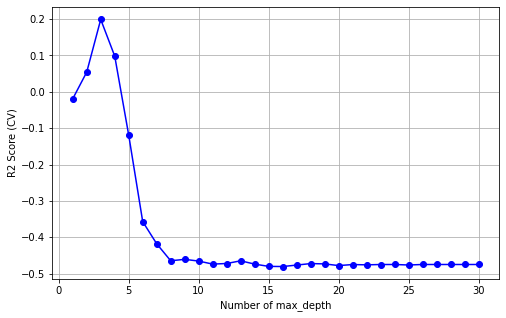

Optimal number of max_depth: 3
Evaluating Training Data
R^2: 0.671, RMSE: 0.081, MAE: 0.058


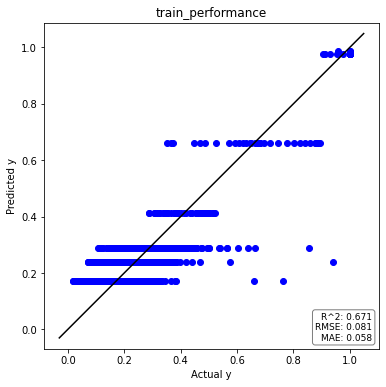

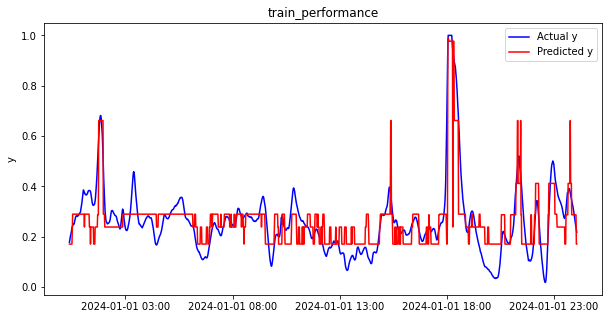

Evaluating Test Data
R^2: 0.439, RMSE: 0.137, MAE: 0.103


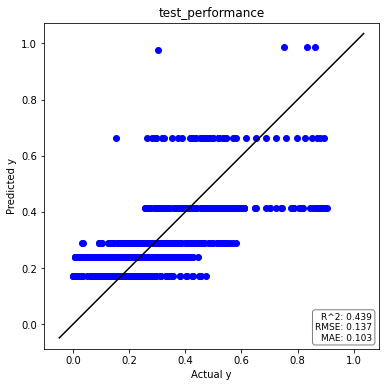

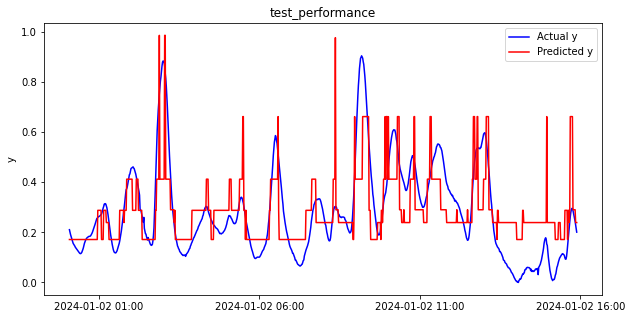

In [27]:
# 関数の実行
optimal_max_depth, dt_final = perform_dt_regression(X, y)

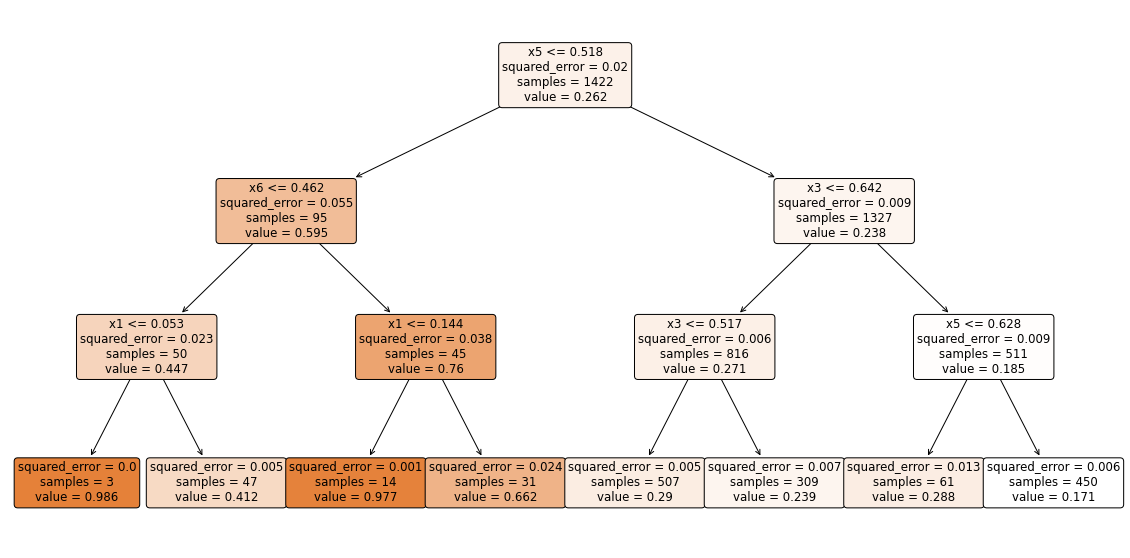

In [28]:
# ツリーマップの作成
fig = plt.figure(figsize=(20, 10))
plot_tree(dt_final, feature_names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], filled=True, rounded=True)
# グラフをPNGファイルとして保存
plt.savefig('Decision Tree Structure_debutan.png', facecolor='white', dpi=500)
plt.show()

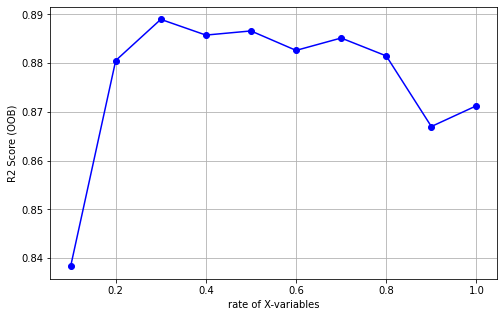

Optimal rate of X-variables: 0.3
Evaluating Training Data
R^2: 0.716, RMSE: 0.075, MAE: 0.055


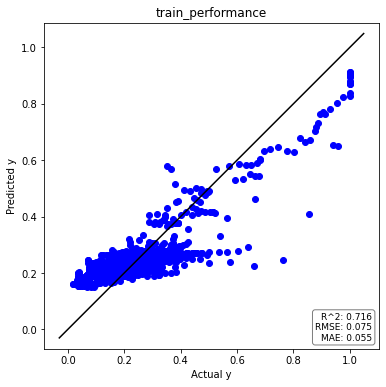

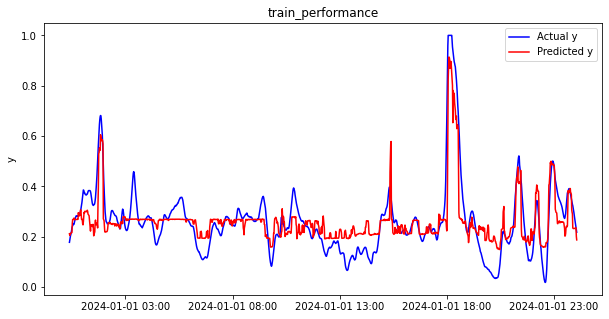

Evaluating Test Data
R^2: 0.554, RMSE: 0.122, MAE: 0.091


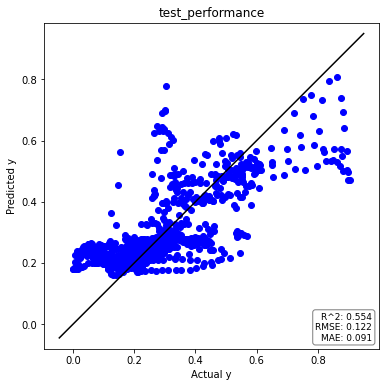

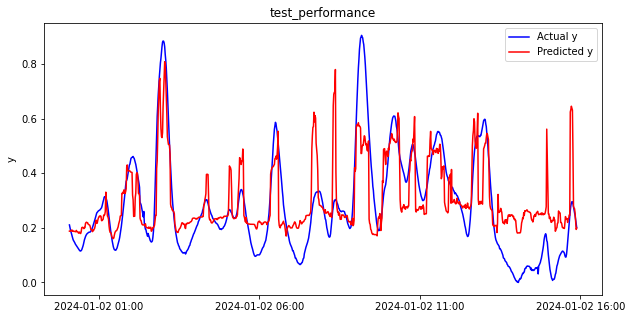

In [29]:
# 関数の実行
optimal_x_variables_rate, rf_final = perform_rf_regression(X, y)